In [1]:
import pandas as pd
import numpy as np

import re
import string

import spacy
import nltk

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tqdm

In [2]:
review_data= pd.read_excel('/kaggle/input/dental-book-reviews/Cleaned_Synthetic_No_Special_Characters.xlsx')
print(review_data.head(5))

   Book ID  Review ID                                       Review Title  \
0      1.0         12  Some of the figures and illustrations are defi...   
1      3.0         48                                                NaN   
2      3.0         49                                                NaN   
3      4.0         54                                                NaN   
4      4.0         64                                                NaN   

                                  Review Description  Review Rating  \
0  Some of the figures and illustrations are defi...            2.0   
1  My book came wet and ripped, looks like it was...            1.0   
2  Only giving 1 star because all the pages are s...            1.0   
3  If I could give it half a star I would. The bo...            1.0   
4  f you want to study anatomy in the "real" sens...            NaN   

   Topic of the review  Stop words extraction  \
0                  NaN                    NaN   
1                 

In [3]:
import spacy
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from spacy.tokens import DocBin
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel
from collections import Counter
import pandas as pd

In [4]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 97.1 MB/s eta 0:00:00:00:010:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=bbd614fd8d1b0d8d17420076f2fd95d8ba8ccdb13bf2f23113b7d1d516a27275
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
  Created wheel for pptree: filename=pptree-3.1-py3-none-any.whl size=4609 sha256=6d0d61d2f9259b06c43efb095339d66620cc4db571bc07ffc7c37846e090b317
  Stored in directory: /root/.cach

In [5]:
import flair
from flair.data import Sentence
from flair.models import SequenceTagger

# Load Spacy for dependency parsing
nlp = spacy.load('en_core_web_sm')

# Load Flair POS tagger model
tagger = SequenceTagger.load("flair/pos-english")

# Load stopwords
stop_words = set(stopwords.words('english'))

# Updated clean_text function
def clean_text(text):
    # Remove punctuation but keep the structure intact
    text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in text])
    # Convert to lowercase and remove short words
    cleaned_text = ' '.join([word.lower() for word in text.split() if len(word) > 2])
    
    # Ensure the text is not empty
    if not cleaned_text.strip():
        return None  # Return None if the cleaned text is empty
    return cleaned_text

# Use Flair for POS tagging and aspect extraction (noun phrases)
def extract_aspect_phrases_with_flair(text):
    if not text:  # Ensure valid input
        return []
    
    sentence = Sentence(text)
    tagger.predict(sentence)
    aspects = []
    
    current_aspect = []
    
    for token in sentence:
        # Check if token is a noun (NN, NNS, NNP, NNPS)
        if token.get_labels('pos')[0].value in ['NN', 'NNS', 'NNP', 'NNPS']:
            current_aspect.append(token.text)  # Add the noun to the current aspect phrase
        else:
            if current_aspect:
                # If we have a collected aspect, join it and reset
                aspects.append(' '.join(current_aspect))
                current_aspect = []  # Reset for the next aspect phrase
    
    # Append the last collected aspect if any
    if current_aspect:
        aspects.append(' '.join(current_aspect))
    
    return aspects

# Combine Review Title and Review Description, and clean
review_data['Raw Text'] = (review_data['Review Title'].fillna('') + " " + review_data['Review Description'].fillna(''))

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

pytorch_model.bin:   0%|          | 0.00/249M [00:00<?, ?B/s]

2024-09-30 00:26:39,192 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [6]:
print(review_data['Raw Text'])

0       Some of the figures and illustrations are defi...
1        My book came wet and ripped, looks like it wa...
2        Only giving 1 star because all the pages are ...
3        If I could give it half a star I would. The b...
4        f you want to study anatomy in the "real" sen...
                              ...                        
1230     Pictures and content are very good and helpfu...
1231     The binding of this book isnâ€™t the best. Af...
1232    Unable to see pictures Pictures are too small ...
1233     The Atlas itself is very well put together wi...
1234     This is really small. I guess that is why it ...
Name: Raw Text, Length: 1235, dtype: object


In [7]:
# # Initialize list for processed reviews
# processed_reviews = []

# i = 0

# # Process reviews
# for review in review_data['Raw Text']:
#     cleaned_review = clean_text(review)
    
#     # Skip if the cleaned review is None
#     if cleaned_review is None:
#         continue
    
#     # Extract aspects
#     aspects = extract_aspect_phrases_with_flair(cleaned_review)
    
#     # Remove stopwords from aspects
#     aspects_no_stopwords = [aspect for aspect in aspects if aspect.lower() not in stop_words]
    
#     # Add to processed reviews
#     processed_reviews.append(aspects_no_stopwords)
    
#     i += 1
#     print("The %d row has been processed, extracted %s" % (i, aspects_no_stopwords)) 

In [8]:
# import pickle

# # Save the processed_reviews to a file
# with open('processed_reviews.pkl', 'wb') as file:
#     pickle.dump(processed_reviews, file)

# print("Processed reviews saved successfully!")

In [9]:
import pickle

# Load the processed_reviews from the file
with open('/kaggle/input/dental-book-reviews/processed_reviews.pkl', 'rb') as file:
    processed_reviews = pickle.load(file)

print("Processed reviews loaded successfully!")

# Print processed reviews
print(processed_reviews)

Processed reviews loaded successfully!
[['figures', 'illustrations', 'book format', 'figures', 'illustrations', 'book format'], ['book', 'looks', 'version', 'cover', 'lot pages'], ['star', 'pages', 'book', 'book', 'cadaver lab room smells', 'cadaver', 'pages', 'books', 'lab', 'way', 'book', 'gloves', 'money'], ['star', 'book', 'hours', 'book', 'set', 'sheets paper', 'anatomy', 'design', 'amazon', 'publisher', 'issues', 'comments'], ['study anatomy', 'sense', 'images', 'book'], ['book', 'photos', 'examples', 'anatomy', 'pages', 'book', 'binding', 'time', 'book chapter chunk pages'], ['endeavor', 'catalog', 'public', 'body', 'fractions', 'whole', 'enterprise', 'use cadavers', 'formaldehyde', 'purposes', 'results', 'doctors', 'donors', 'loss', 'person', 'patients', 'artists', 'beauty', 'anatomy', 'abomination', 'bodies', 'state', 'chemicals', 'book', 'project', 'resource', 'structures', 'colors', 'subjects', 'person'], ['anatomy atlas', 'school', 'anatomy atlas', 'images', 'quality', 'tex

In [10]:
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained RoBERTa model and tokenizer from Hugging Face
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Function to get embeddings from RoBERTa
def get_roberta_embedding(phrase):
    inputs = tokenizer(phrase, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the CLS token embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Get embeddings for each unique phrase in the list of phrases and store in a dictionary
phrase_embeddings_dict = {}

for review_phrases in processed_reviews:
    for phrase in review_phrases:
        if phrase not in phrase_embeddings_dict:  # Check if the phrase is already processed
            embedding = get_roberta_embedding(phrase)
            phrase_embeddings_dict[phrase] = embedding

# Convert the dictionary values to a numpy array (embeddings) and store phrases separately
unique_phrases = list(phrase_embeddings_dict.keys())
phrase_embeddings = np.array(list(phrase_embeddings_dict.values()))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

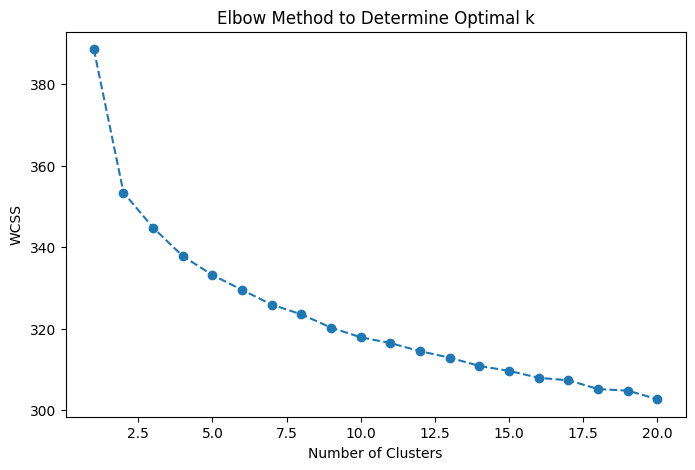

In [12]:
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Elbow Method to determine optimal number of clusters
def calculate_wcss(data):
    wcss = []
    for k in range(1, 21):  # Test k
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS for different values of k
wcss = calculate_wcss(phrase_embeddings)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [13]:
# Calculate WCSS for a range of cluster values
wcss = calculate_wcss(phrase_embeddings)

# Calculate first and second derivatives
first_derivative = np.diff(wcss)  # First derivative of WCSS
second_derivative = np.diff(first_derivative)  # Second derivative

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

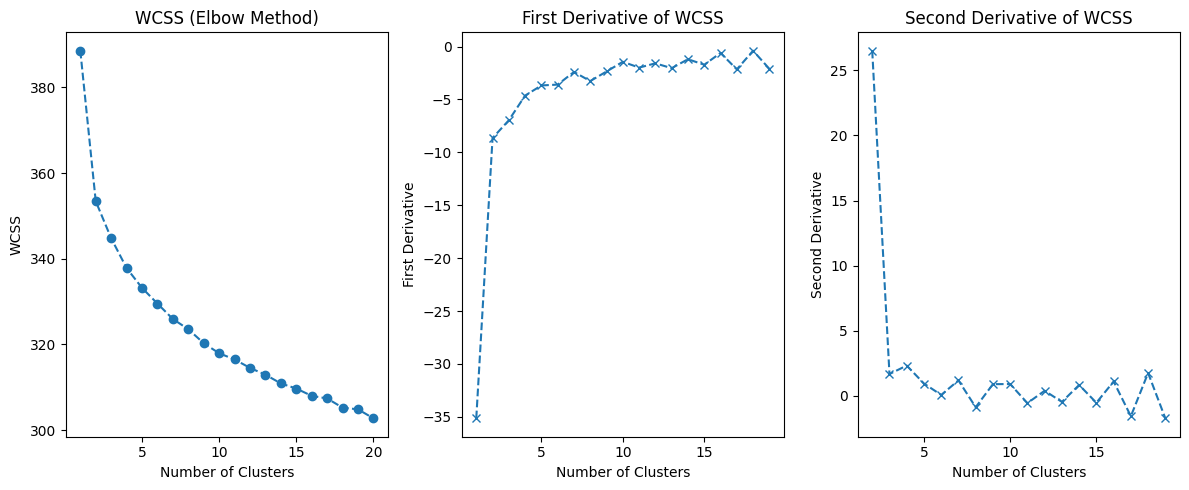

In [14]:
# Plot the WCSS and the first and second derivatives
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('WCSS (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.subplot(1, 3, 2)
plt.plot(range(1, 20), first_derivative, marker='x', linestyle='--')
plt.title('First Derivative of WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('First Derivative')

plt.subplot(1, 3, 3)
plt.plot(range(2, 20), second_derivative, marker='x', linestyle='--')
plt.title('Second Derivative of WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('Second Derivative')

plt.tight_layout()
plt.show()

In [15]:
# Apply K-means with the optimal number of clusters
optimal_k = 7  # Choose the optimal k based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(phrase_embeddings)

# Get cluster assignments
cluster_labels = kmeans.labels_

# Dimensionality Reduction for Visualization (PCA + t-SNE)
# Apply PCA first to reduce dimensions before t-SNE
pca = PCA(n_components=50)
pca_result = pca.fit_transform(phrase_embeddings)

# Apply t-SNE for better visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Create a DataFrame for easy plotting
df = pd.DataFrame(tsne_result, columns=['x', 'y'])
df['phrase'] = unique_phrases
df['cluster'] = cluster_labels

# Step 4: Calculate distances to the cluster centroids
centroids = kmeans.cluster_centers_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

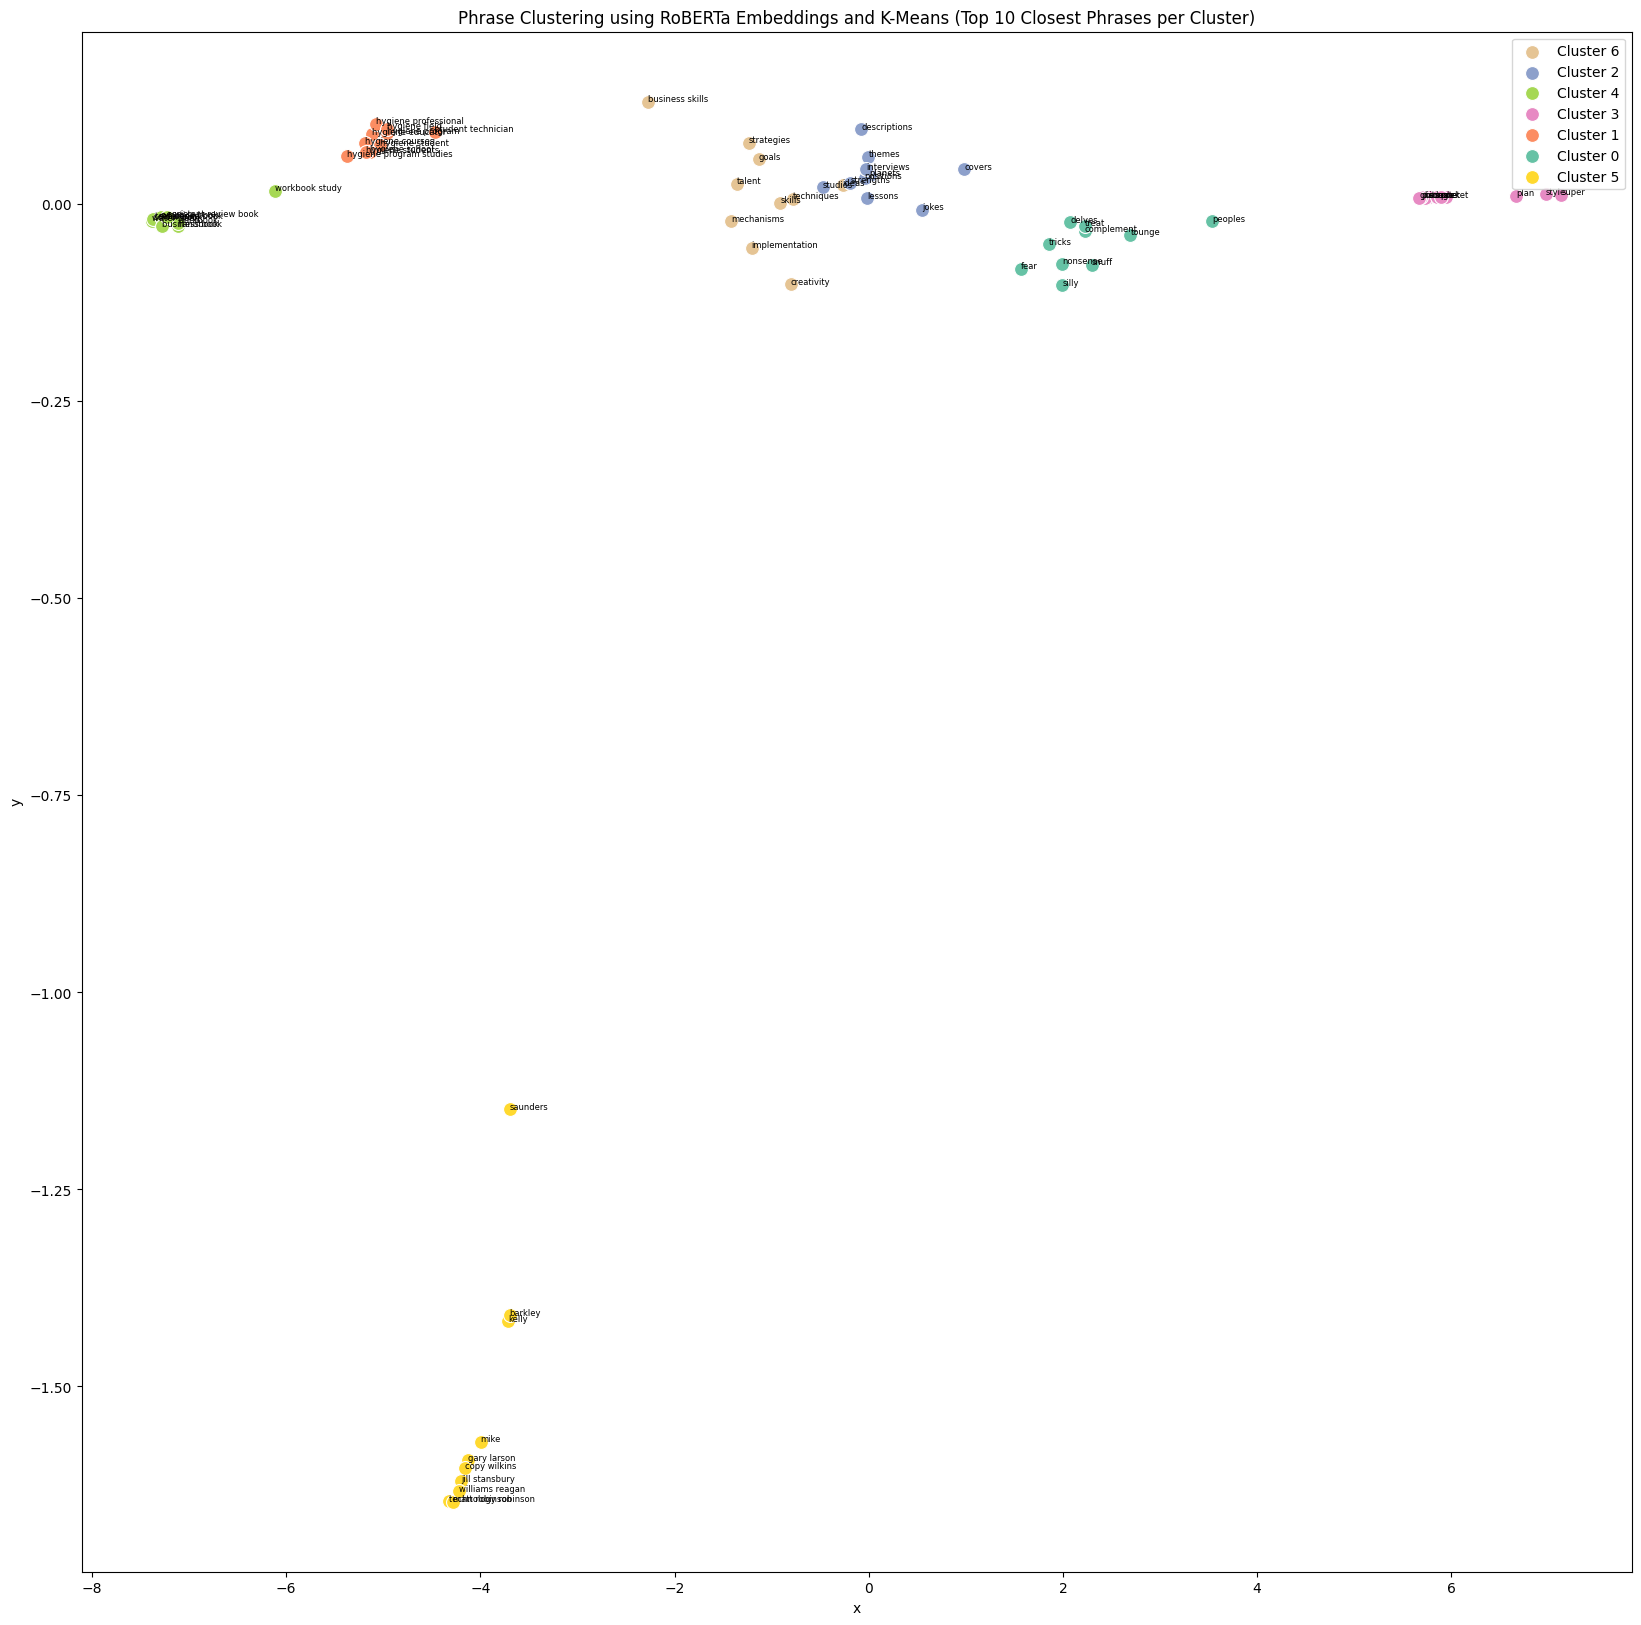

In [16]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# Add a new column to store the distance to the cluster centroid
df['distance_to_centroid'] = [
    euclidean_distance(phrase_embeddings[i], centroids[cluster])
    for i, cluster in enumerate(df['cluster'])
]

# Select the 10 closest phrases to the centroid for each cluster
representative_phrases = {}

for cluster_id in df['cluster'].unique():
    # Filter phrases belonging to the current cluster
    cluster_phrases = df[df['cluster'] == cluster_id]
    # Sort by distance to the centroid
    closest_phrases = cluster_phrases.nsmallest(10, 'distance_to_centroid')
    representative_phrases[cluster_id] = closest_phrases

# Visualization using Matplotlib and Seaborn with better label readability
plt.figure(figsize=(20, 20))  # Increase figure size for better clarity
colors = sns.color_palette('Set2', len(df['cluster'].unique()))

# Adjust label offset and font size
label_offset_x = 0  # Adjust the horizontal spacing
label_offset_y = 0  # Adjust the vertical spacing
font_size = 6  # Decrease font size for readability

# Plot only the 5 closest phrases for each cluster (you can change back to 10 if needed)
for cluster_id, phrases in representative_phrases.items():
    sns.scatterplot(x='x', y='y', data=phrases, color=colors[cluster_id], label=f'Cluster {cluster_id}', s=100)
    
    # Add text annotations for each phrase with adjusted offsets
    for i in range(phrases.shape[0]):
        plt.text(phrases['x'].iloc[i] + label_offset_x, phrases['y'].iloc[i] + label_offset_y, 
                 phrases['phrase'].iloc[i], fontsize=font_size)

plt.title("Phrase Clustering using RoBERTa Embeddings and K-Means (Top 10 Closest Phrases per Cluster)")
plt.legend(loc='best')
plt.show()

In [17]:
# Sort and order the phrases in ascending order for each cluster (based on distance to centroid)
ordered_phrases_by_cluster = {}

for cluster_id in df['cluster'].unique():
    # Filter phrases belonging to the current cluster and sort by distance to centroid in ascending order
    cluster_phrases = df[df['cluster'] == cluster_id].sort_values(by='distance_to_centroid', ascending=True)
    ordered_phrases_by_cluster[cluster_id] = cluster_phrases['phrase'].values[:20]  # Select top 20 phrases

# Display the ordered phrases for each cluster
for cluster_id, phrases in ordered_phrases_by_cluster.items():
    print(f"\nCluster {cluster_id} (Ordered by Distance to Centroid, Ascending - Top 20):")
    for phrase in phrases:
        print(f"- {phrase}")


Cluster 6 (Ordered by Distance to Centroid, Ascending - Top 20):
- ideas
- strategies
- talent
- skills
- implementation
- techniques
- goals
- creativity
- mechanisms
- business skills
- writing style
- improvements
- technique
- profession
- confession
- discipline
- layers
- facility
- complications
- plans

Cluster 2 (Ordered by Distance to Centroid, Ascending - Top 20):
- lessons
- planets
- jokes
- positions
- themes
- covers
- studios
- interviews
- descriptions
- strengths
- introductions
- typos
- practices
- packets
- regulations
- appreciation
- reminders
- doctors
- friendships
- messages

Cluster 4 (Ordered by Distance to Centroid, Ascending - Top 20):
- handbook
- workbook
- water book
- reference book
- text book
- colour book
- practice book
- workbook study
- business book
- assistant review book
- picture book
- type book
- book book
- quality book
- dat book
- coffee table book
- assistant book
- pocket book
- chem book
- texbook

Cluster 3 (Ordered by Distance to C

In [18]:
# # Load the POS tagger model from Flair
# tagger = SequenceTagger.load("flair/pos-english")

# # Example sentence
# sentence = Sentence("The battery life of this phone is extremely long-lasting and the screen is crisp and clear.")

# # Predict POS tags
# tagger.predict(sentence)

# # Extract opinion phrases (adjectives and adverbs)
# opinion_phrases = []
# current_opinion = []

# # Loop through tokens and collect multi-word opinion phrases
# for token in sentence:
#     pos_tag = token.get_labels('pos')[0].value
#     if pos_tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'RB']:  # Looking for adjectives (JJ) and adverbs (RB)
#         current_opinion.append(token.text)  # Collect the opinion words
#     else:
#         if current_opinion:
#             # Join consecutive opinion words to form a phrase and append to the result
#             opinion_phrases.append(' '.join(current_opinion))
#             current_opinion = []  # Reset for the next phrase

# # Append the last opinion phrase if any
# if current_opinion:
#     opinion_phrases.append(' '.join(current_opinion))

# print("Opinion Phrases:", opinion_phrases)

In [33]:
# Function to extract opinion phrases using Flair
def extract_opinion_phrases(sentence_text):
#     # Load the POS tagger from Flair
#     tagger = SequenceTagger.load("flair/pos-english")
    
    # Process the sentence
    sentence = Sentence(sentence_text)
    tagger.predict(sentence)
    
    # Extract opinion phrases (adjectives, adverbs, and nouns)
    opinion_phrases = []
    current_opinion = []
    
    for token in sentence:
        pos_tag = token.get_labels('pos')[0].value
        if pos_tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'RB']:  # Focus on adjectives, adverbs, and nouns
            current_opinion.append(token.text)
        else:
            if current_opinion:
                opinion_phrases.append(' '.join(current_opinion))
                current_opinion = []
    
    if current_opinion:
        opinion_phrases.append(' '.join(current_opinion))
    
    return opinion_phrases

In [20]:
# opinion_phrases = []

# i = 0

# # Process reviews
# for review in review_data['Raw Text']:
#     cleaned_review = clean_text(review)
    
#     # Skip if the cleaned review is None
#     if cleaned_review is None:
#         continue
    
#     # Extract
#     phrases = extract_opinion_phrases(cleaned_review)
    
#     # Remove stopwords
#     phrase_no_stopwords = [phrase for phrase in phrases if phrase.lower() not in stop_words]
    
#     # Add to processed reviews
#     opinion_phrases.append(phrase_no_stopwords)
    
#     i += 1
#     print("The %d row has been processed, extracted %s" % (i, phrase_no_stopwords)) 

In [34]:
# opinion_phrases = []

# # Process reviews
# for i, review in enumerate(review_data['Raw Text']):
#     cleaned_review = clean_text(review)
    
#     # If the cleaned review is None, append an empty list
#     if cleaned_review is None:
#         opinion_phrases.append([])
#         continue
    
#     # Extract opinion phrases
#     phrases = extract_opinion_phrases(cleaned_review)
    
#     # Remove stopwords
#     phrase_no_stopwords = [phrase for phrase in phrases if phrase.lower() not in stop_words]
    
#     # Ensure that we append something for every review, even if no phrases were found
#     opinion_phrases.append(phrase_no_stopwords)
    
#     print(f"The {i+1}th row has been processed, extracted {phrase_no_stopwords}")

# # Ensure the lengths match
# print(f"Number of reviews: {len(review_data['Raw Text'])}")
# print(f"Number of opinion phrases: {len(opinion_phrases)}")

The 1th row has been processed, extracted ['figures', 'illustrations', 'deficient book format', 'figures', 'illustrations', 'deficient book format']
The 2th row has been processed, extracted ['book', 'wet', 'looks', 'previously', 'new version', 'cover also little worn', 'lot pages']
The 3th row has been processed, extracted ['star', 'pages', 'still', 'book', 'book', 'cadaver lab room smells just', 'cadaver', 'sticky greasy pages just', 'books', 'lab', 'only way able', 'book', 'gloves', 'money']
The 4th row has been processed, extracted ['half star', 'book', 'apart', 'first few hours', 'initially', 'bearable', 'entire book', 'loose set', 'sheets paper', 'anatomy even', 'challenging poor design', 'amazon', 'publisher', 'very little', 'issues', 'similar past comments']
The 5th row has been processed, extracted ['study anatomy', 'real sense not just', 'elegant', 'cartoonish images', 'book', 'not disappointed']
The 6th row has been processed, extracted ['book', 'fantastic', 'photos', 'pheno

In [35]:
import pickle

# Save the processed_reviews to a file
with open('processed_opinion_phrases.pkl', 'wb') as file:
    pickle.dump(opinion_phrases, file)

print("Saved successfully!")

Saved successfully!


In [22]:
import pickle

# Load the processed_reviews from the file
with open('/kaggle/input/dental-book-reviews/processed_opinion_phrases.pkl', 'rb') as file:
    opinion_phrases = pickle.load(file)

print("Loaded successfully!")

# Print processed reviews
print(opinion_phrases)

Loaded successfully!
[['figures', 'illustrations', 'deficient book format', 'figures', 'illustrations', 'deficient book format'], ['book', 'wet', 'looks', 'previously', 'new version', 'cover also little worn', 'lot pages'], ['star', 'pages', 'still', 'book', 'book', 'cadaver lab room smells just', 'cadaver', 'sticky greasy pages just', 'books', 'lab', 'only way able', 'book', 'gloves', 'money'], ['half star', 'book', 'apart', 'first few hours', 'initially', 'bearable', 'entire book', 'loose set', 'sheets paper', 'anatomy even', 'challenging poor design', 'amazon', 'publisher', 'very little', 'issues', 'similar past comments'], ['study anatomy', 'real sense not just', 'elegant', 'cartoonish images', 'book', 'not disappointed'], ['book', 'fantastic', 'photos', 'phenomenal', 'real good examples human anatomy', 'pages', 'book literally', 'out there good binding', 'time', 'book chapter chunk pages literally'], ['possibly', 'endeavor', 'catalog', 'public', 'human body', 'vital fractions', 'w

In [25]:
import torch

# Check if GPU is available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [30]:
print(len(review_data['Raw Text']))

1235


In [31]:
print(len(opinion_phrases))

1227


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the ABASE model
class ABASE(nn.Module):
    def __init__(self):
        super(ABASE, self).__init__()
        # Load pre-trained RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        # Linear layer to map opinion phrase embeddings back to sentence embedding
        self.linear = nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size)
    
    def forward(self, review_input_ids, review_attention_mask, opinion_input_ids, opinion_attention_mask):
        # Ensure the input tensors are moved to the same device as the model
        review_input_ids, review_attention_mask = review_input_ids.to(device), review_attention_mask.to(device)
        opinion_input_ids, opinion_attention_mask = opinion_input_ids.to(device), opinion_attention_mask.to(device)

        # Step 1: Get embeddings for the full review (from [CLS] token)
        review_outputs = self.roberta(input_ids=review_input_ids, attention_mask=review_attention_mask)
        review_embedding = review_outputs.last_hidden_state[:, 0, :]  # [CLS] token as review embedding
        
        # Step 2: Get embeddings for the opinion phrases
        opinion_outputs = self.roberta(input_ids=opinion_input_ids, attention_mask=opinion_attention_mask)
        opinion_embedding = opinion_outputs.last_hidden_state[:, 0, :]  
        
        # Step 3: Reconstruct the review embedding from the opinion embedding
        reconstructed_embedding = self.linear(opinion_embedding)
        
        return review_embedding, reconstructed_embedding

# Define reconstruction loss
def reconstruction_loss(original_embedding, reconstructed_embedding):
    return torch.mean((original_embedding - reconstructed_embedding) ** 2)

In [37]:
# Tokenization function
def tokenize_text(text, max_length=256):
    return tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
model = ABASE().to(device)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 1

for epoch in range(num_epochs):
    for i, review in enumerate(review_data['Raw Text']):
        # Tokenize the full review
        review_inputs = tokenize_text(review)

        # Tokenize the opinion phrases for the current review
        opinions = ' '.join(opinion_phrases[i])  # Join phrases as a single string
        opinion_inputs = tokenize_text(opinions)
        
        # Forward pass through the model
        review_embedding, reconstructed_embedding = model(
            review_input_ids=review_inputs['input_ids'], 
            review_attention_mask=review_inputs['attention_mask'], 
            opinion_input_ids=opinion_inputs['input_ids'], 
            opinion_attention_mask=opinion_inputs['attention_mask']
        )
        
        # Compute reconstruction loss
        loss = reconstruction_loss(review_embedding, reconstructed_embedding)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Review [{i+1}/{len(review_data['Raw Text'])}], Loss: {loss.item()}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/1], Review [1/1235], Loss: 0.2082841992378235
Epoch [1/1], Review [2/1235], Loss: 0.16231027245521545
Epoch [1/1], Review [3/1235], Loss: 0.13214588165283203
Epoch [1/1], Review [4/1235], Loss: 0.10685010999441147
Epoch [1/1], Review [5/1235], Loss: 0.08905303478240967
Epoch [1/1], Review [6/1235], Loss: 0.06010674685239792
Epoch [1/1], Review [7/1235], Loss: 0.0484950952231884
Epoch [1/1], Review [8/1235], Loss: 0.03264434635639191
Epoch [1/1], Review [9/1235], Loss: 0.021723126992583275
Epoch [1/1], Review [10/1235], Loss: 0.014577295631170273
Epoch [1/1], Review [11/1235], Loss: 0.009326046332716942
Epoch [1/1], Review [12/1235], Loss: 0.007286936044692993
Epoch [1/1], Review [13/1235], Loss: 0.005926381330937147
Epoch [1/1], Review [14/1235], Loss: 0.0058209337294101715
Epoch [1/1], Review [15/1235], Loss: 0.0038587856106460094
Epoch [1/1], Review [16/1235], Loss: 0.0030497475527226925
Epoch [1/1], Review [17/1235], Loss: 0.0026682622265070677
Epoch [1/1], Review [18/1235]

In [53]:
# Save the entire model
torch.save(model, 'ABASE_model.pth')

In [83]:
# Load the entire model
model = torch.load('/kaggle/working/ABASE_model.pth')
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_30/580033123.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/ABASE_model.pth')


ABASE(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

In [100]:
import torch
import matplotlib.pyplot as plt

# Function to predict using the trained model
def predict_opinion_sentiment(model, review_text, tokenizer):
    # Step 1: Extract opinion phrases using the function `extract_opinion_phrases`
    opinion_phrases = extract_opinion_phrases(clean_text(review_text))
    
    # If no opinion phrases were found, return
    if not opinion_phrases:
        print("No opinion phrases found in the review.")
        return None
    
    # Step 2: Tokenize the full review and each individual opinion phrase
    review_inputs = tokenize_text(review_text)
    
    # Initialize a list to store individual embeddings for opinion phrases
    opinion_embeddings = []
    
    for phrase in opinion_phrases:
        opinion_inputs = tokenize_text(phrase)  # Tokenize each phrase individually
        with torch.no_grad():
            review_embedding, opinion_embedding = model(
                review_input_ids=review_inputs['input_ids'].to(device),  # Move to the correct device
                review_attention_mask=review_inputs['attention_mask'].to(device),
                opinion_input_ids=opinion_inputs['input_ids'].to(device), 
                opinion_attention_mask=opinion_inputs['attention_mask'].to(device)
            )
        opinion_embeddings.append(opinion_embedding.squeeze(0))  # Add the embedding to the list
    
    return review_embedding, torch.stack(opinion_embeddings), opinion_phrases

# Function to predict opinion sentiment and visualize attention for a review
def Attention_for_review_result(model, review_text, tokenizer):
    # Step 1: Extract opinion phrases and predict embeddings
    review_embedding, opinion_embeddings, opinion_phrases = predict_opinion_sentiment(model, review_text, tokenizer)
    
    # If no opinion phrases were found, return
    if not opinion_phrases:
        print("No opinion phrases found in the review.")
        return None
    
    # Step 2: Ensure the review embedding is a 2D tensor
    review_embedding_tensor = review_embedding.squeeze(0)
    
    # Step 3: Calculate attention weights using cosine similarity between review and opinion embeddings
    attention_weights = torch.cosine_similarity(review_embedding_tensor, opinion_embeddings, dim=-1).cpu().numpy()
    
    # Step 4: Normalize the attention weights
    attention_weights = (attention_weights - attention_weights.min()) / (attention_weights.max() - attention_weights.min())
    
    attention_weights = attention_weights / attention_weights.sum()
    
    # Print the opinion phrases and corresponding attention weights
    for phrase, weight in zip(opinion_phrases, attention_weights):
        print(f"Opinion Phrase: {phrase} - Attention Weight: {weight:.4f}")
    
    return opinion_phrases, attention_weights
    
# # Function to predict opinion sentiment and visualize attention for a review
# def Attention_for_review(model, review_text, tokenizer):
#     # Step 1: Extract opinion phrases and predict embeddings
#     review_embedding, opinion_embeddings, opinion_phrases = predict_opinion_sentiment(model, review_text, tokenizer)
    
#     # If no opinion phrases were found, return
#     if not opinion_phrases:
#         print("No opinion phrases found in the review.")
#         return None
    
#     # Step 2: Ensure the review embedding is a 2D tensor
#     review_embedding_tensor = review_embedding.squeeze(0)
    
#     # Step 3: Calculate attention weights using cosine similarity between review and opinion embeddings
#     attention_weights = torch.cosine_similarity(review_embedding_tensor, opinion_embeddings, dim=-1).cpu().numpy()
    
#     # Step 4: Normalize the attention weights
#     attention_weights = (attention_weights - attention_weights.min()) / (attention_weights.max() - attention_weights.min())
    
#     attention_weights = attention_weights / attention_weights.sum()
        
#     return opinion_phrases, attention_weights

# Function to predict opinion sentiment and visualize attention for a review
def Attention_for_review(model, review_text, tokenizer):
    # Step 1: Clean the review text
    cleaned_review_text = clean_text(review_text)

    # If the cleaned review text is invalid, return None
    if not cleaned_review_text or cleaned_review_text.strip() == "":
        print("Skipping empty or invalid cleaned review.")
        return None
    
    # Step 2: Extract opinion phrases and predict embeddings
    result = predict_opinion_sentiment(model, cleaned_review_text, tokenizer)
    
    # Check if result is None before unpacking
    if result is None:
        print(f"No valid opinion phrases found for review: {review_text}")
        return None
    
    review_embedding, opinion_embeddings, opinion_phrases = result

    # Step 3: Ensure the review embedding is a 2D tensor
    review_embedding_tensor = review_embedding.squeeze(0)
    
    # Step 4: Calculate attention weights using cosine similarity between review and opinion embeddings
    attention_weights = torch.cosine_similarity(review_embedding_tensor, opinion_embeddings, dim=-1).cpu().numpy()
    
    # Step 5: Normalize the attention weights to sum up to 1
    attention_weights = (attention_weights - attention_weights.min()) / (attention_weights.max() - attention_weights.min())
    attention_weights = attention_weights / attention_weights.sum()
    
    return opinion_phrases, attention_weights

# Visualization: Plot the attention map with Matplotlib
def plot_attention(opinion_phrases, attention_weights):
    plt.figure(figsize=(10, 6))
    plt.barh(opinion_phrases, attention_weights, color='skyblue')
    plt.xlabel('Attention Weights')
    plt.title('Attention Map for Opinion Phrases')
    plt.gca().invert_yaxis()
    plt.show()

Opinion Phrase: book - Attention Weight: 0.0000
Opinion Phrase: wet - Attention Weight: 0.0915
Opinion Phrase: looks - Attention Weight: 0.1610
Opinion Phrase: previously - Attention Weight: 0.1366
Opinion Phrase: new version - Attention Weight: 0.1638
Opinion Phrase: cover also little worn - Attention Weight: 0.2846
Opinion Phrase: lot pages - Attention Weight: 0.1626


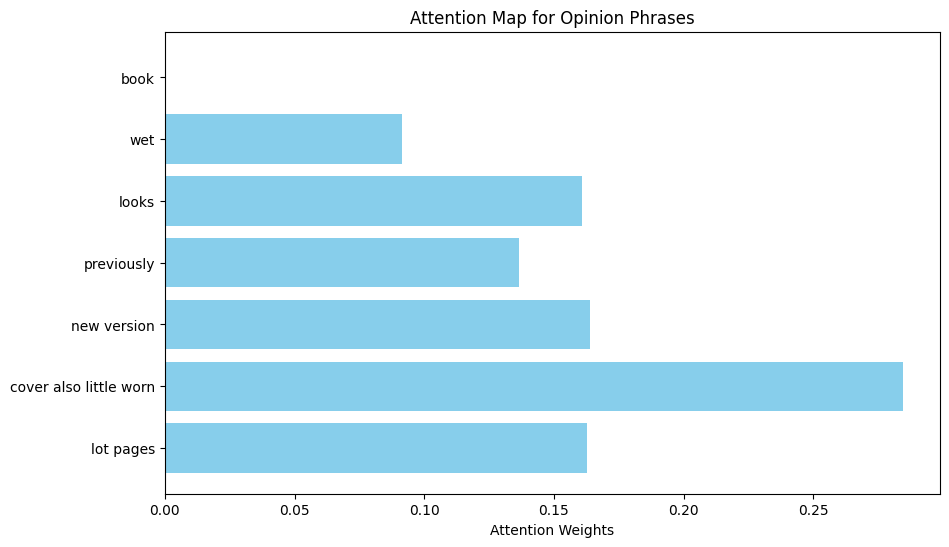

In [93]:
# Example usage
review_text = "My book came wet and ripped, looks like it was previously used, although I bought a new version of it. The cover is also a little worn out and a lot of pages are folded."
opinion_phrases, attention_weights = Attention_for_review_result(model, review_text, tokenizer)
plot_attention(opinion_phrases, attention_weights)

In [69]:
# Create a dictionary to store unique indices of rows belonging to each cluster and the 'Other' cluster
indices_by_cluster = {i: set() for i in range(optimal_k)}  # Using a set to remove duplicates
indices_by_cluster['Other'] = set()  # Create a set for the 'Other' cluster

# Loop through each processed review (list of phrases)
for idx, phrases_in_review in enumerate(processed_reviews):
    # Skip the row if "Synthetic" column is set to "synthetic"
    if review_data["Synthetic"].iloc[idx] == "synthetic":
        continue

    added_to_cluster = False  # Flag to check if a phrase belongs to any cluster

    # For each phrase in the review, find the corresponding cluster and store the row index
    for phrase in phrases_in_review:
        # Find the cluster this phrase belongs to
        if phrase in df['phrase'].values:
            phrase_cluster = df[df['phrase'] == phrase]['cluster'].values[0]
            # Add the row index (review index) to the corresponding cluster
            indices_by_cluster[phrase_cluster].add(idx)
            added_to_cluster = True  # Set flag to True if the review has a phrase in a cluster

    # If none of the phrases belong to any cluster, add the review index to 'Other' cluster
    if not added_to_cluster:
        indices_by_cluster['Other'].add(idx)

# Convert the set back to a list to make it easier to display
for cluster_id in indices_by_cluster:
    indices_by_cluster[cluster_id] = list(indices_by_cluster[cluster_id])

# Display the indices for each cluster, including the 'Other' cluster
for cluster_id, indices in indices_by_cluster.items():
    print(f"\nCluster {cluster_id} (Unique Row indices):")
    print(indices)


Cluster 0 (Unique Row indices):
[1221, 2, 6, 519, 8, 10, 23, 536, 537, 26, 538, 539, 540, 542, 545, 547, 548, 37, 550, 551, 552, 554, 556, 558, 48, 562, 51, 564, 56, 59, 571, 572, 63, 65, 68, 581, 588, 77, 81, 83, 84, 85, 597, 87, 90, 605, 94, 607, 97, 612, 101, 102, 613, 104, 105, 106, 616, 108, 109, 620, 112, 114, 115, 116, 629, 118, 119, 121, 123, 124, 125, 635, 127, 128, 129, 639, 131, 132, 133, 134, 135, 139, 144, 657, 658, 659, 660, 149, 150, 662, 152, 666, 155, 156, 157, 158, 159, 160, 162, 163, 674, 165, 166, 167, 675, 169, 170, 171, 172, 173, 174, 176, 178, 181, 183, 184, 185, 186, 187, 695, 189, 190, 191, 700, 701, 194, 195, 702, 197, 198, 199, 200, 201, 705, 711, 713, 715, 206, 716, 721, 210, 211, 723, 214, 727, 728, 218, 219, 730, 222, 225, 737, 227, 228, 739, 230, 740, 235, 747, 237, 239, 242, 756, 246, 247, 248, 761, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 772, 263, 773, 781, 784, 799, 829, 830, 835, 676, 854, 855, 857, 858, 865, 866, 867, 868, 704, 1218, 506]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


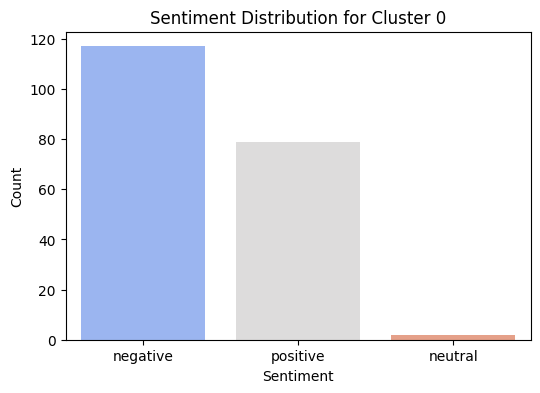

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


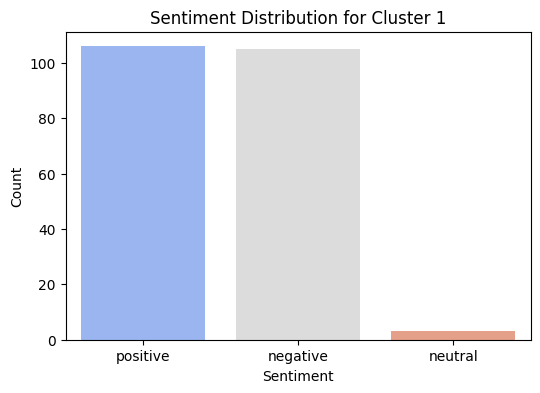

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


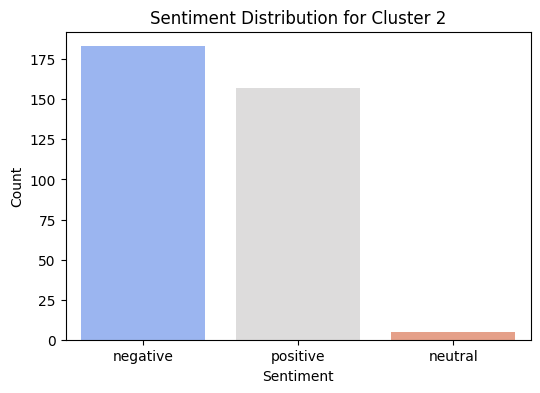

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


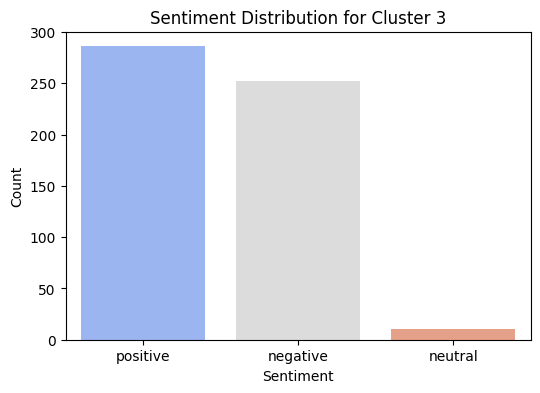

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


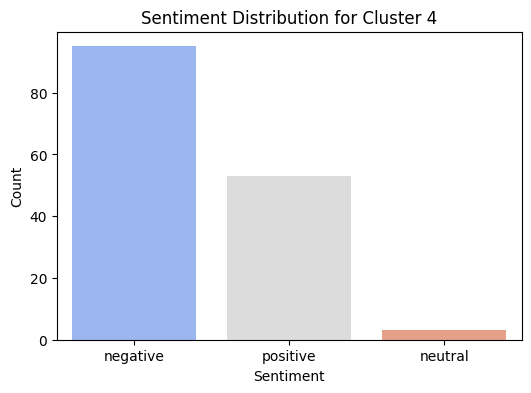

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


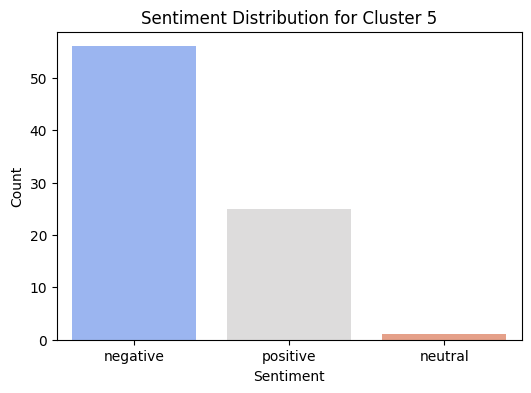

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


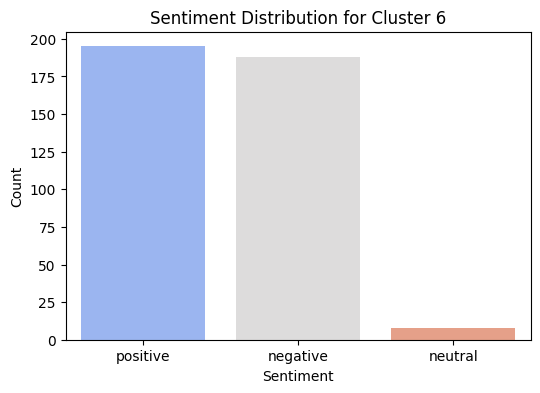

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


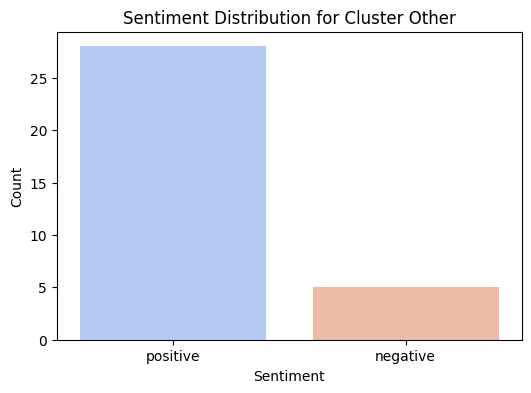

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_distribution = {}

for cluster_id, indices in indices_by_cluster.items():
    sentiments = review_data.loc[indices, "Sentiment"]
    sentiment_counts = sentiments.value_counts()
    sentiment_distribution[cluster_id] = sentiment_counts

    # Plot the sentiment distribution for each cluster
    plt.figure(figsize=(6, 4))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
    plt.title(f"Sentiment Distribution for Cluster {cluster_id}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

In [76]:
# # Loop through reviews and process them before calling extract_opinion_phrases()
# top_attention_phrases = {}

# for cluster_id, indices in indices_by_cluster.items():
#     top_attention_phrases[cluster_id] = []
#     for idx in indices:
#         review_text = review_data.loc[idx, "Raw Text"]
        
#         # Clean the review text first
#         cleaned_review_text = clean_text(review_text)
        
#         # Check if the cleaned review text is valid (not None or empty)
#         if not cleaned_review_text or cleaned_review_text.strip() == "":
#             print(f"Skipping empty or invalid review at index {idx}.")
#             continue
        
#         # Predict using the attention model and extract attention weights
#         result = predict_opinion_sentiment(model, cleaned_review_text, tokenizer)
        
#         # If the result is None, skip this review
#         if result is None:
#             print(f"No opinion phrases found in the review at index {idx}.")
#             continue
        
#         review_embedding, opinion_embeddings, opinion_phrases = result
        
#         # Calculate the attention weights
#         attention_weights = torch.cosine_similarity(review_embedding.squeeze(0), opinion_embeddings, dim=-1).cpu().numpy()
        
#         # Get the top 3 phrases
#         top_3_indices = np.argsort(attention_weights)[-3:]  # Get indices of top 3 attention weights
#         top_3_phrases = [opinion_phrases[i] for i in top_3_indices]
#         top_attention_phrases[cluster_id].append((review_text, top_3_phrases))

# # Visualize the top phrases with their respective attention scores
# for cluster_id, reviews in top_attention_phrases.items():
#     print(f"\nCluster {cluster_id} - Top Attention Phrases:")
#     for review, phrases in reviews:
#         print(f"Review: {review}")
#         print(f"Top 3 Attention Phrases: {phrases}\n")

Skipping empty or invalid review at index 549.
No opinion phrases found in the review.
No opinion phrases found in the review at index 596.
Skipping empty or invalid review at index 820.
No opinion phrases found in the review.
No opinion phrases found in the review at index 525.
Skipping empty or invalid review at index 549.
No opinion phrases found in the review.
No opinion phrases found in the review at index 596.
No opinion phrases found in the review.
No opinion phrases found in the review at index 617.
No opinion phrases found in the review.
No opinion phrases found in the review at index 636.
No opinion phrases found in the review.
No opinion phrases found in the review at index 671.
No opinion phrases found in the review.
No opinion phrases found in the review at index 831.
No opinion phrases found in the review.
No opinion phrases found in the review at index 525.
Skipping empty or invalid review at index 549.
No opinion phrases found in the review.
No opinion phrases found in 

In [101]:
import json

# Loop through reviews and process them before calling extract_opinion_phrases
top_attention_phrases = {}

for cluster_id, indices in indices_by_cluster.items():
    top_attention_phrases[cluster_id] = []  # Initialize storage for each cluster
    print(f"Processing Cluster {cluster_id}...")
    
    for idx in indices:
        review_text = review_data.loc[idx, "Raw Text"]
        
        # Use the Attention_for_review function to get opinion phrases and attention weights
        result = Attention_for_review(model, review_text, tokenizer)
        
        # If there are no opinion phrases, skip this review
        if result is None:
            print(f"No opinion phrases found in the review at index {idx}.")
            continue
        
        opinion_phrases, attention_weights = result

        # Get the top 3 phrases and their corresponding weights
        top_3_indices = np.argsort(attention_weights)[-3:]  # Get indices of top 3 attention weights
        top_3_phrases = [(opinion_phrases[i], attention_weights[i]) for i in top_3_indices]
        
        # Append the review text and top phrases with weights to the cluster storage
        top_attention_phrases[cluster_id].append({
            "review_text": review_text,
            "top_phrases": top_3_phrases,
            "all_phrases": opinion_phrases,  # Save all phrases for future use
            "all_weights": attention_weights.tolist()  # Save all attention weights for further analysis
        })
    
    # After processing all reviews in the cluster, display the saved results
    print(f"Finished processing Cluster {cluster_id}")
    for entry in top_attention_phrases[cluster_id]:
        print(f"Review: {entry['review_text']}")
        for phrase, weight in entry['top_phrases']:
            print(f"Phrase: '{phrase}' - Attention Weight: {weight:.4f}")

    print("\n" + "="*40 + "\n")  # Separator for readability between clusters

Processing Cluster 0...


/tmp/ipykernel_30/3012400888.py:110: RuntimeWarning: invalid value encountered in divide
  attention_weights = (attention_weights - attention_weights.min()) / (attention_weights.max() - attention_weights.min())


Finished processing Cluster 0
Review:  This BOOK quality is ALL PAPER whereas the Original book quality is glossy paper.
Your paying a quite high price & you get is a copy.
This is just disappointing AMAZON.
Overall the information are all the same in the books.
Phrase: 'amazon overall' - Attention Weight: 0.1687
Phrase: 'book quality' - Attention Weight: 0.1837
Phrase: 'original book quality glossy paper' - Attention Weight: 0.3042
Review:  Only giving 1 star because all the pages are still in the book. To me, this book seems to have come from a cadaver lab room. It smells just like a cadaver. Has sticky greasy pages just like the books in the lab do. The only way I am able to use this book is while wearing gloves. I wish I wouldâ€™ve just returned this for my money back.
Phrase: 'only way able' - Attention Weight: 0.1204
Phrase: 'cadaver lab room smells just' - Attention Weight: 0.1727
Phrase: 'sticky greasy pages just' - Attention Weight: 0.1730
Review:  This is possibly the greates

TypeError: Object of type float32 is not JSON serializable

In [104]:
# Function to convert tensors and non-serializable types into Python-native types
def make_serializable(top_attention_phrases):
    for cluster_id, reviews in top_attention_phrases.items():
        for review in reviews:
            # Convert attention weights in 'top_phrases' to float
            review["top_phrases"] = [(phrase, float(weight)) for phrase, weight in review["top_phrases"]]
            
            # Convert attention weights in 'all_weights' to list of floats
            review["all_weights"] = [float(weight) for weight in review["all_weights"]]
    
    return top_attention_phrases

# Modify the top_attention_phrases to make it serializable
top_attention_phrases_serializable = make_serializable(top_attention_phrases)

# Save the modified data to a JSON file
with open("top_attention_phrases_serializable.json", "w") as f:
    json.dump(top_attention_phrases_serializable, f)

print("Successfully saved the top_attention_phrases with attention weights in a serializable format.")

Successfully saved the top_attention_phrases with attention weights in a serializable format.


In [107]:
with open("/kaggle/working/top_attention_phrases_serializable.json", "r") as f:
    top_attention_phrases = json.load(f)

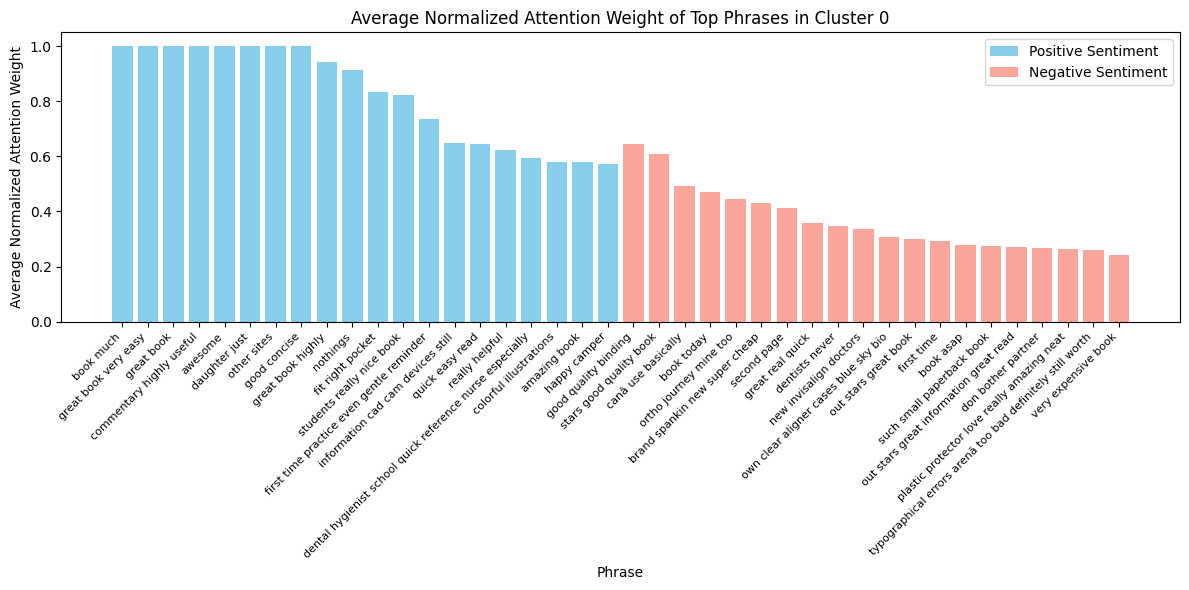

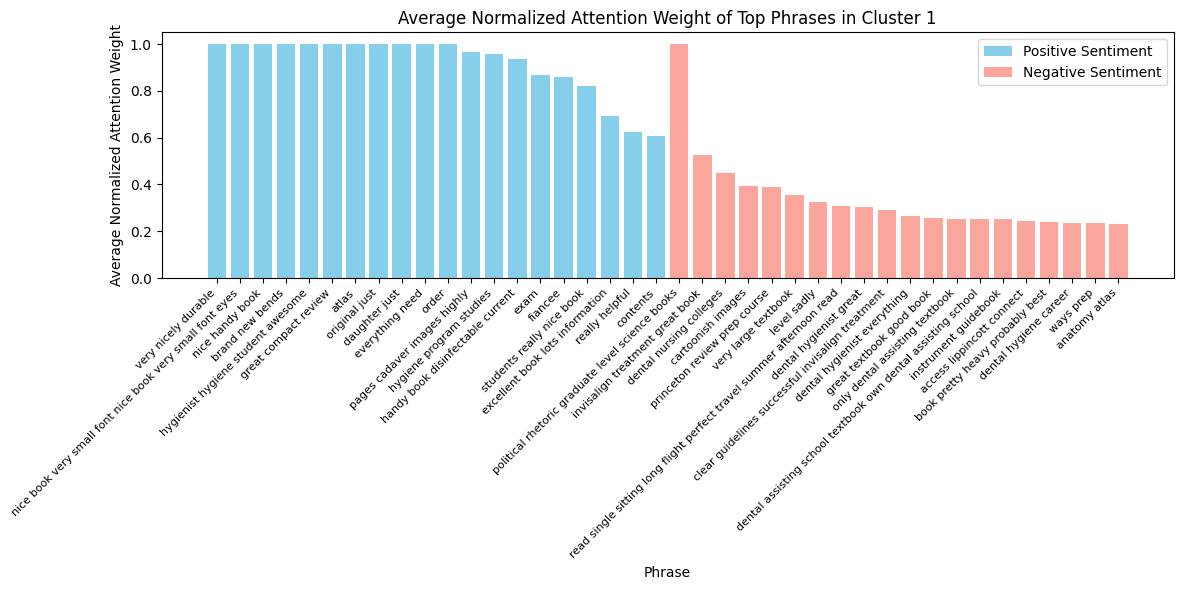

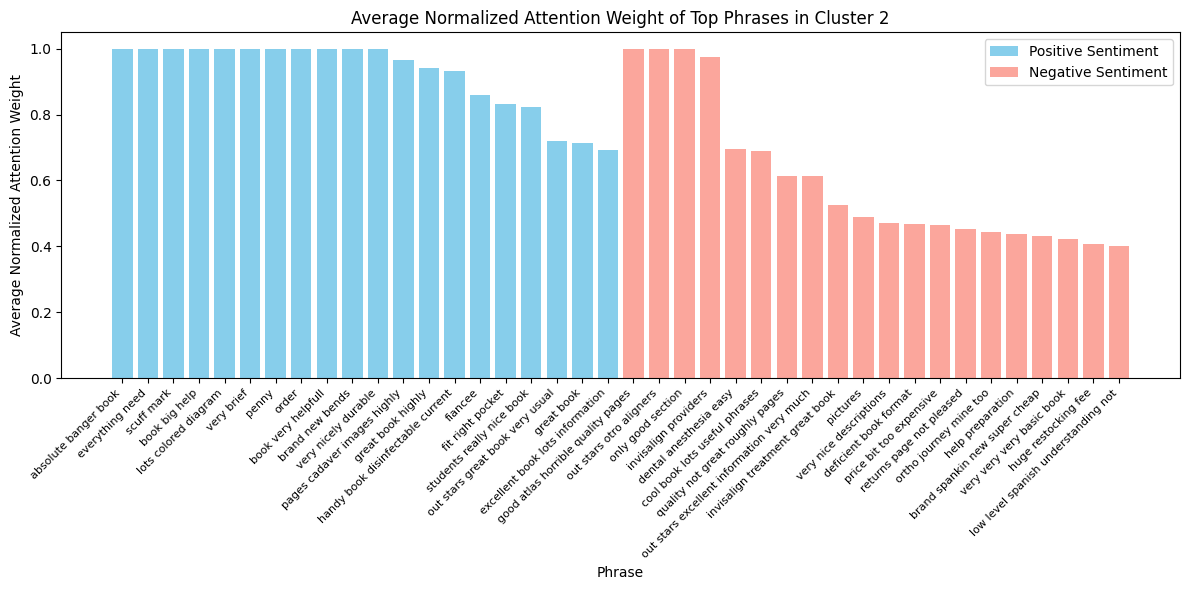

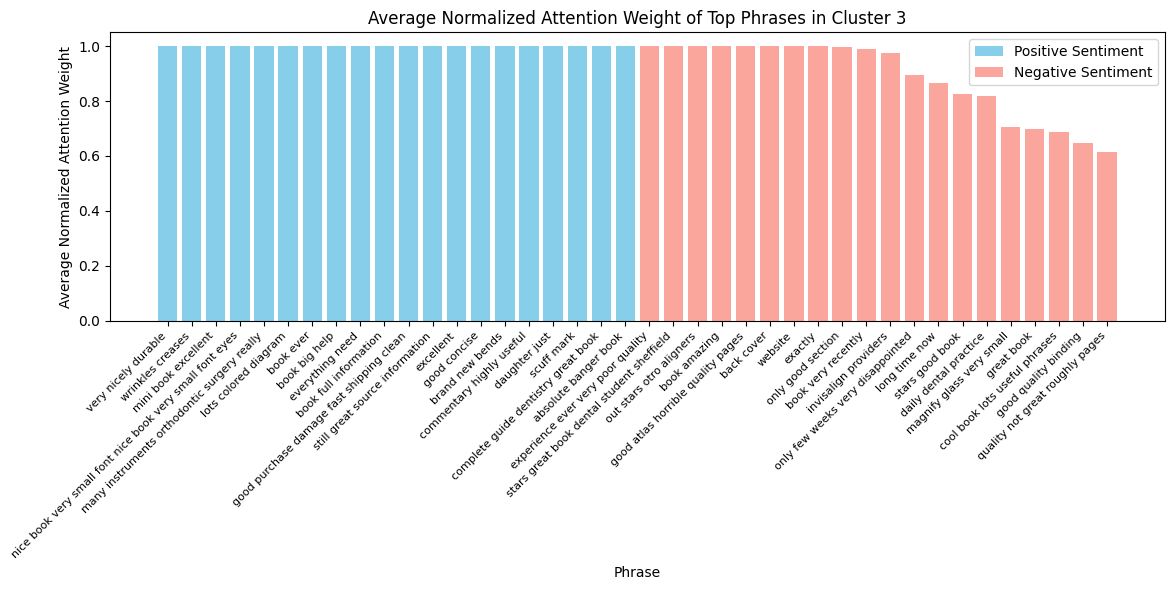

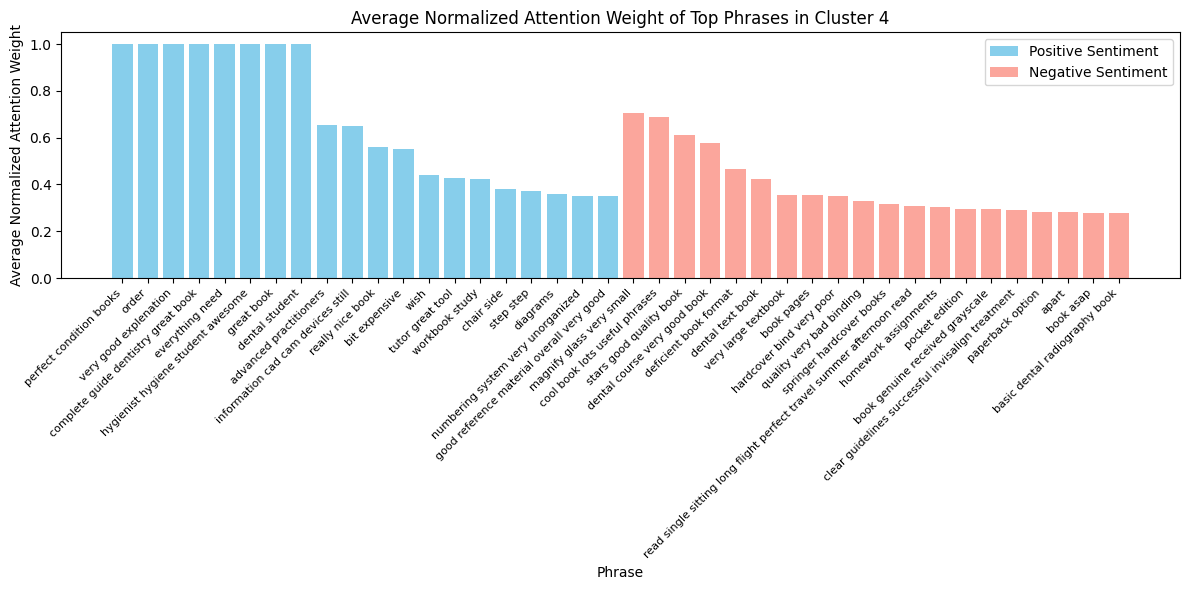

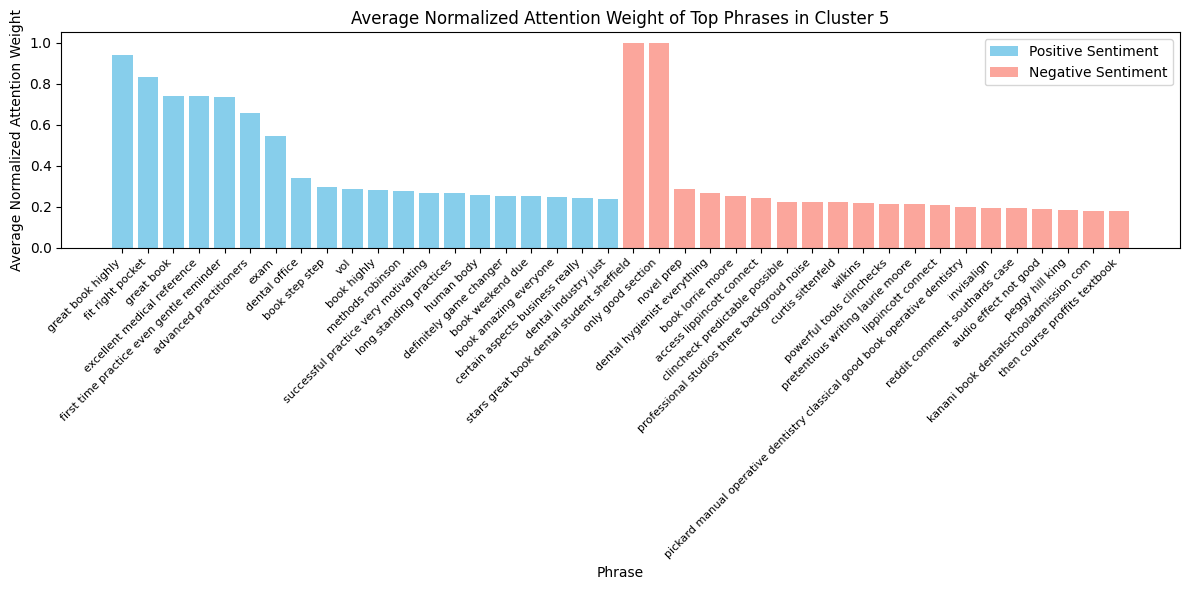

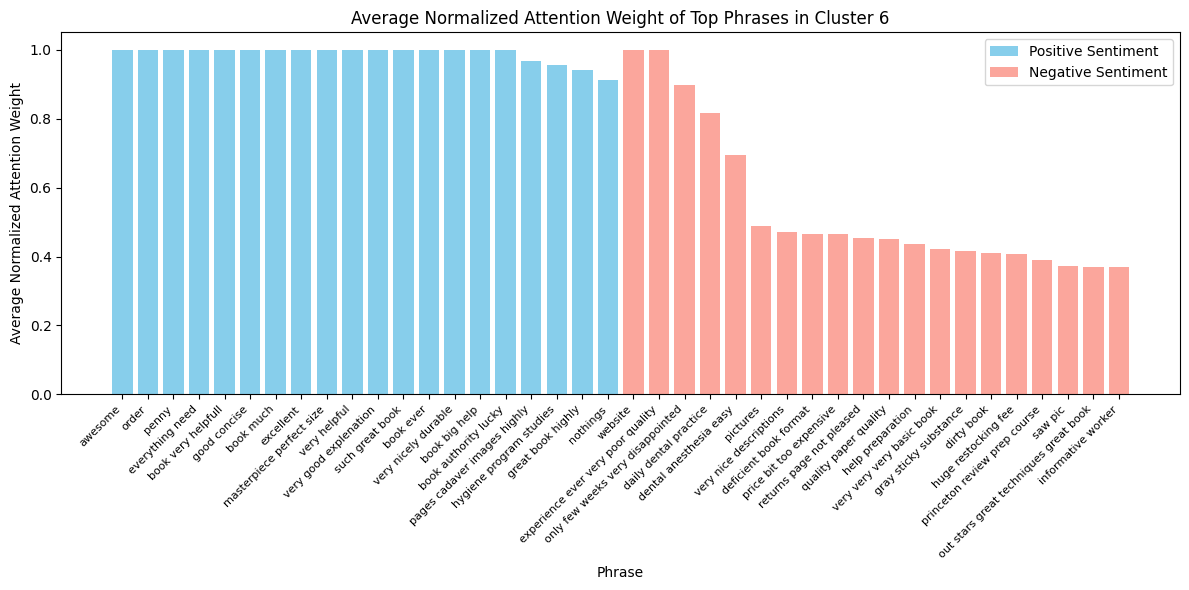

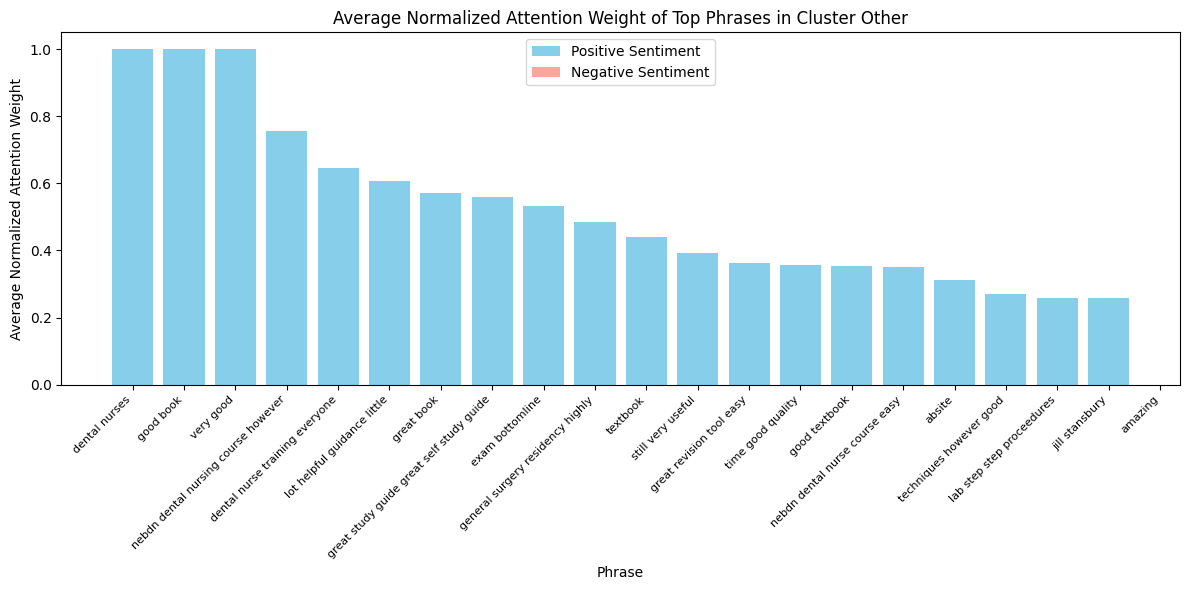

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to store sentiment-based phrase impacts for each cluster
cluster_phrase_impact = {}

# Loop through each cluster and its corresponding reviews
for cluster_id, reviews in top_attention_phrases.items():
    # Initialize storage for positive and negative phrases in this cluster
    cluster_phrase_impact[cluster_id] = {'positive': [], 'negative': []}
    
    # Loop through each review in the cluster
    for entry in reviews:
        review_text = entry['review_text']
        sentiment = review_data.loc[review_data['Raw Text'] == review_text, "Sentiment"].values[0]
        
        for phrase, weight in entry['top_phrases']:
            # Append phrase and weight to either positive or negative list based on sentiment
            if sentiment == "positive":
                cluster_phrase_impact[cluster_id]['positive'].append((phrase, weight))
            elif sentiment == "negative":
                cluster_phrase_impact[cluster_id]['negative'].append((phrase, weight))

# Plot aggregated impact for each cluster with smaller font size for x-ticks and rotated labels
for cluster_id, sentiment_data in cluster_phrase_impact.items():
    positive_phrases = sentiment_data['positive']
    negative_phrases = sentiment_data['negative']
    
    # Create dataframes for positive and negative sentiments
    positive_df = pd.DataFrame(positive_phrases, columns=['Phrase', 'Weight'])
    negative_df = pd.DataFrame(negative_phrases, columns=['Phrase', 'Weight'])
    
    # Group by phrases and calculate mean normalized weight
    positive_avg = positive_df.groupby('Phrase')['Weight'].mean().sort_values(ascending=False).head(20)
    negative_avg = negative_df.groupby('Phrase')['Weight'].mean().sort_values(ascending=False).head(20)
    
    # Plot the average impact for positive and negative phrases
    plt.figure(figsize=(12, 6))
    plt.bar(positive_avg.index, positive_avg.values, color='skyblue', label='Positive Sentiment')
    plt.bar(negative_avg.index, negative_avg.values, color='salmon', label='Negative Sentiment', alpha=0.7)
    plt.title(f"Average Normalized Attention Weight of Top Phrases in Cluster {cluster_id}")
    plt.xlabel("Phrase")
    plt.ylabel("Average Normalized Attention Weight")
    plt.legend()
    
    # Rotate the x-axis labels, reduce font size, and set tight layout
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.tight_layout()  # Ensure everything fits nicely in the plot
    plt.show()


In [109]:
from scipy.stats import chi2_contingency

# Create a contingency table for sentiments across clusters
contingency_table = pd.DataFrame(sentiment_distribution).fillna(0)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 51.06987134398699, p-value: 4.037223711243767e-06
